In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import stim
print(stim.__version__)

import matplotlib.pyplot as plt
import numpy as np
import math

#from ldpc import bp_decoder, bposd_decoder
import time
from src.utils import rank
#from src.codes_q import create_bivariate_bicycle_codes, create_circulant_matrix
from src.build_circuit import build_QRM_circuit, dem_to_check_matrices
from src.QRMcode import QuantumReedMuller

QRM = QuantumReedMuller(2, 2, 6)
polynomials = [[1,2,3], [3,4,5], [1,2,4], [3,4,6], [1,5,6], [2,5,6]]
QRM.gauge_operators(polynomials)


check matrix shape (88, 1192), max (row, column) weight (296, 22), min (row, column) weight (41, 1)


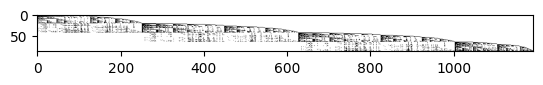

In [ ]:
z_basis = True
num_repeat=3
circuit = build_QRM_circuit(QRM, p=0.001, num_repeat=num_repeat)
dem = circuit.detector_error_model()
chk, obs, priors, col_dict = dem_to_check_matrices(dem, return_col_dict=True)
num_row, num_col = chk.shape
num_detectors = int(num_row/(num_repeat+1))
chk_row_wt = np.sum(chk, axis=1)
chk_col_wt = np.sum(chk, axis=0)
print(f"check matrix shape {chk.shape}, max (row, column) weight ({np.max(chk_row_wt)}, {np.max(chk_col_wt)}),",
      f"min (row, column) weight ({np.min(chk_row_wt)}, {np.min(chk_col_wt)})")
plt.imshow(chk.toarray(), cmap="gist_yarg")
#plt.imshow(obs.toarray(), cmap="gist_yarg")

Each column in the parity check matrix represent a single fault realization of the syndrome measurement circuit. Each row represents a detector, upper rows are detectors in the earlier rounds. In Stim's jargon, a detector is a result that is guaranteed to be zero in the absence of noise. Here a detector is the XORed syndrome measurement results from previous round and current round.

Using the notation in [1] Section 6:
$$m'=(m_1, m_2\oplus m_1, m_3\oplus m_2, ..., m_{N_c}\oplus m_{N_c-1})$$
each coordinate represents a detector. $m_i$ is the syndrome measurement result from round $i$.

[1] High-threshold and low-overhead fault-tolerant quantum memory

Since a single fault can affect detectors from at most two rounds, the next cell permutes the parity check matrix (PCM) into 
- faults that trigger detectors in the current round only
- faults that trigger current and next round
- faults that trigger next round only
- and so on

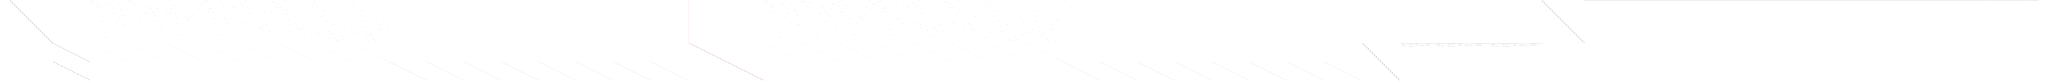

In [ ]:
circuit.diagram("timeline-svg")

{(0, 22): 0, (0, 44): 1, (22, 44): 2, (22, 66): 3, (44, 66): 4, (44, 88): 5, (66, 88): 6}


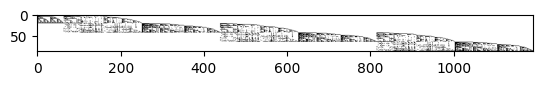

In [ ]:
lower_bounds = []
upper_bounds = []
i = 0
num_detectors=num_detectors
while i < num_row:
    lower_bounds.append(i)
    upper_bounds.append(i+num_detectors)
    if i+num_detectors*2 > num_row:
        break
    lower_bounds.append(i)
    upper_bounds.append(i+num_detectors*2)
    i += num_detectors
region_dict = {}
for i, (l,u) in enumerate(zip(lower_bounds, upper_bounds)):
    region_dict[(l,u)] = i
region_cols = [[] for _ in range(len(region_dict))]
print(region_dict)
for i in range(num_col):
    nnz_col = np.nonzero(chk[:,i])[0]
    if not len(nnz_col)==0:
        l = nnz_col.min() // num_detectors * num_detectors
        u = (nnz_col.max() // num_detectors + 1) * num_detectors
        region_cols[region_dict[(l,u)]].append(i)
#plt.imshow(chk.toarray(), cmap="gist_yarg")
chk = np.concatenate([chk[:,col].toarray() for col in region_cols], axis=1)
obs = np.concatenate([obs[:,col].toarray() for col in region_cols], axis=1)
priors = np.concatenate([priors[col] for col in region_cols])
num_row, num_col = chk.shape
plt.imshow(chk, cmap="gist_yarg")

The XOR operations in the detector error model naturally create a spatially-coupled like code, for which sliding-window is a standard decoding technique.


The following cell peeks into the block matrices (green or yellow window) on the diagonal. It partitions the fault mechanisms according to their prior probabilities.



#non-zeros / #edges = 3341
among 384 faults, 84 triggers previous round only, 0 triggers next round only, 300 triggers both rounds


IndexError: index 3 is out of bounds for axis 0 with size 3

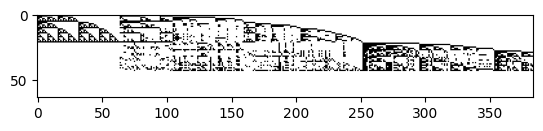

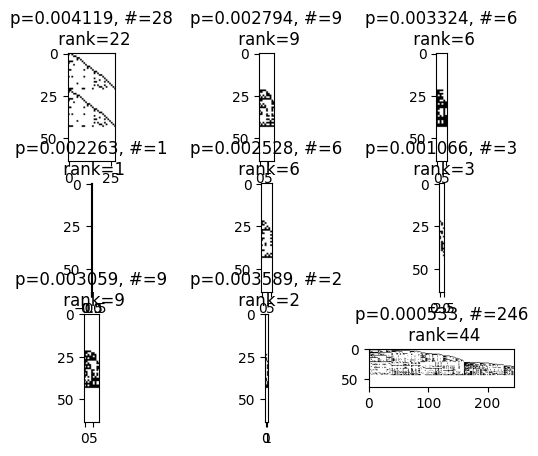

In [ ]:
encoding_round = True  # green window
# encoding_round = False # yellow windows
N = QRM.N
N_half = int(QRM.N/2)
if encoding_round:
    # encoding round
    submat = chk[:N,:6*N]
    p = priors[:6*N]
else:
    # syndrome measurement rounds
    submat = chk[N_half:N_half*3,6*N:11*N]
    p = priors[6*N:11*N]

plt.imshow(submat, cmap="gist_yarg")
nnz_x, nnz_y = np.nonzero(submat)
print(f"#non-zeros / #edges = {len(nnz_x)}")

w, h = submat.shape
all_previous_round = []
all_next_round = []
both_rounds = []
for i in range(h):
    nnz_col = np.nonzero(submat[:,i])[0]
    if (nnz_col < N_half).all():
        all_previous_round.append(i)
    elif (nnz_col >= N_half).all():
        all_next_round.append(i)
    else:
        both_rounds.append(i)
print(f"among {h} faults, {len(all_previous_round)} triggers previous round only,",
      f"{len(all_next_round)} triggers next round only, {len(both_rounds)} triggers both rounds")

# partition the matrix according to prior probabilities
p_value_set = list(set(p))
set_len = len(p_value_set)
fig, ax = plt.subplots(3 if encoding_round else 2, 3)
for s in range(set_len):
    num = (p==p_value_set[s]).astype(int).sum()
    subsubmat = submat[:,p==p_value_set[s]]
    ax[s//3,s%3].imshow(subsubmat, cmap="gist_yarg")
    ax[s//3,s%3].set_title(f"p={p_value_set[s]:5f}, #={num}\n rank={rank(subsubmat)}")

for s in range(set_len, len(ax)*3):
    ax[s//3,s%3].axis("off")
    
plt.tight_layout()

A (W,F) sliding window decoder takes a window containing detectors from W consecutive round, and move the window forward by F rounds each time. In each window, a combination of faults (possibly the most probable one) is found using BP in the classical case that explains the detector results from this window. However, BP in the quantum case suffers from convergence issue, in the next notebook, BP+OSD is used in each window. Decisions for faults that trigger the detectors from the first F rounds are commited and other decisions are discarded $^1$. For example, after decoding for the first window, the decisions for the columns between the first two red dots are commited.

[1] In the classical case, the BP state in the current window can be used to guide the decoding in the next window. However, BP convergence is too bad in the quantum case to be used for the next window.

The above figure shows the windows for the (3,1) decoding.

In the next cell, all the anchors (red dots) are identified and windows are extracted using them.

It is noticed that the columns at rightmost of the window can be merged into an identity matrix, whose new prior is the sum of priors for those columns. This identity matrix is a standard technique (called "virtual nodes") used in noisy syndrome decoding (e.g. phenomenonlogical noise). It is not needed in the last window, as the last round of syndrome measurement is noiseless.

To toggle between different level of column merging, change `method` below to `0` (no merging), `1` (mild merging, most recommended), `2` (merge all columns that trigger only the detectors from the last round in the window).

[(0, 0), (22, 252), (44, 628), (66, 1004), (88, 1192)]


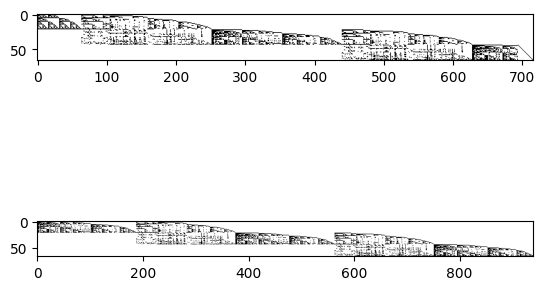

In [ ]:
anchors = []
method = 1 # try value in [0,1,2]
j = 0
for i in range(num_col):
    nnz_col = np.nonzero(chk[:,i])[0]
    if (nnz_col.min() >= j):
        anchors.append((j, i))
        j += num_detectors
anchors.append((num_row, num_col))
print(anchors)

W, F = 3, 1
num_win = math.ceil((len(anchors)-W+F-1) / F)
chk_submats = []
fig, ax = plt.subplots(num_win, 1)
top_left = 0
i = 0
for i in range(num_win):
    a = anchors[top_left]
    bottom_right = min(top_left + W, len(anchors)-1)
    b = anchors[bottom_right]

    if i != num_win-1 and method != 0: # not the last round
        c = anchors[top_left + W - 1]
        if method == 1:
            c = (c[0], c[1]+num_detectors*3) if z_basis else (c[0], c[1]+N)
#             c = (c[0], c[1]+num_detectors*3) # try also this for x basis
        noisy_syndrome_prior = np.sum(chk[c[0]:b[0],c[1]:b[1]] * priors[c[1]:b[1]], axis=1)
        noisy_syndrome = np.zeros((num_detectors*W,num_detectors))
        noisy_syndrome[-num_detectors:,:] = np.eye(num_detectors)# * noisy_syndrome_prior
        mat = chk[a[0]:b[0],a[1]:c[1]]
        mat = np.hstack((mat, noisy_syndrome))
    else: # method == 0 or last round
        mat = chk[a[0]:b[0],a[1]:b[1]]
    chk_submats.append(mat)
    ax[i].imshow(mat, cmap="gist_yarg")
    top_left += F
